# MNIST dataset training
The algorithms is taken from [3B1B](https://youtu.be/aircAruvnKk)

The TS library is used only to download the dataset

### Libs and dataset loading

In [2]:
from typing import Callable
import numpy.typing as npt

from dataclasses import dataclass
from enum import Enum
import random as rnd

import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

c:\Program Files\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
(_ds_train, _ds_test), _ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)
_ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
# Using individual cell in order to reset the datasets just in case

ds_train = tfds.as_dataframe(
    _ds_train, _ds_info
)
ds_test = tfds.as_dataframe(
    _ds_test, _ds_info
)

### Creating data preparation pipeline

In [5]:
def preparation_pipeline(ds: pd.DataFrame):
    # Normalizing (unint8 -> float32) and flattening input
    ds["image"] = ds["image"].apply(lambda el: el.reshape((-1,)) / 255.)
    # Hot-encoding output
    ds["label"] = ds["label"].apply(lambda el: 1. * (np.arange(10) == el))
    # Renaming the columns
    ds.rename({"image": "x", "label": "y"}, inplace=True)


# Applying pipeline
for ds in [ds_train, ds_test]:
    preparation_pipeline(ds)
# Shuffling with pd method sample
ds_train = ds_train.sample(frac=1).reset_index(drop=True)

ds_train.iloc[0]["image"].shape

(784,)

## Recurrent formulas:
### Some reference
<img src="./images/ref1.png" width="700"/>

The recurent formulas are the initial bounds of our model, which we are then using to derive the training steps.

Basically, we could define our model as $ F(x) = y $, but, as it must be more complex than this, we make some expansion.

As we are dealing with the neural network, it is much better to store weights between two layers in a 2d matrix:
$$ \displaystyle
W^{(l)}_{m\leftarrow n} = 
\begin{pmatrix}
    w^{(l)}_{11} & w^{(l)}_{12} & \dots & w^{(l)}_{1n} \\
    w^{(l)}_{21} & w^{(l)}_{22} & \dots & w^{(l)}_{2n} \\
        \vdots & \vdots & \ddots & \vdots \\
    w^{(l)}_{m1} & w^{(l)}_{m2} & \dots & w^{(l)}_{mn} \\
\end{pmatrix},
$$
Where $ w^{(l)}_{ij} $ denotes weight from neuron $i$ to neuron $j$ in layer $l$.

As we are approaching matrix math, let us denote **($*$)** as a **matrix multiplication** and **($\cdot$)** as **element-wise multiplication** (and as this operation doesn't affects the dimentionality, often this dot could be just omited 🙃). Please also note, that having the element-wise multiplication gives us the right to define in the same way the **element-wise division**.

Let also $W$ would be the array, holding all of these matrixes:
$$ W = [\;\underbrace{W^{(0)}, W^{(1)}, \dots, W^{(L-2)}}_{L-1}\;] $$
<div></div>

But now lets define the neuron function and its output.
Let $raw^{(l)} = [raw^{(l)}_1, raw^{(l)}_2, \dots, raw^{(l)}_i, \dots, raw^{(l)}_n]$
would be the input, that goes to the neuron $i$ in layer $l$.
And let the $A_f^{(l)}: \mathbb{R}\rightarrow \mathbb{R}$ - an activation function of neurons in the layer $l$ and $A_d^{(l)}$ - its derivative.
Okay, now we are finally able to define the output of the neuron layer $l$ as $out^{(l)} = [out^{(l)}_1, out^{(l)}_2, \dots, out^{(l)}_i, \dots, out^{(l)}_n]$, where $out^{(l)}_i$ denotes output of $i$ -th neuron.

It is also quite a crutial thing not to mess up the indexes. And so, please note that while let we have $L$ layers of neurons, there are only $L-1$ "weighted connections" between them, thus we have only L-1 elements of $W$ array respectively. And this means that there are also $L$ inputs/outputs of the each neuron layer, which we would also store in one list, following the $W$ model:
$$ raw = [\;\underbrace{raw^{(0)}, raw^{(1)}, \dots, raw^{(L-1)}}_{L}\;] $$
$$ out = [\;\underbrace{out^{(0)}, out^{(1)}, \dots, out^{(L-1)}}_{L}\;] $$
<div></div>

Taking the things said before into account, we are finally could define the "function" $F$:
$$
F: \begin{cases}
out^{(0)} = x; \\
raw^{(l)} = W^{(l-1)} * out^{(l-1)} + b^{(l-1)}; \\
out^{(l)} = A_f^{(l)}(raw^{(l)}); \\
y = out^{(L-1)};
\end{cases}
$$
(Where $b^{(l)}$ is a bias of $l$ -th layer, and has the same dimentionality as $W^{(l)} * out^{(l-1)}$)

$$ C = \sum_i{(y_i - y_i^*)^2} = |y - y^*| $$

## Layers class

In [6]:
@dataclass
class ActivationFunction:
    name: str
    # The function callable
    f: Callable[[np.ndarray], np.ndarray]
    # The derivative callable of function
    d: Callable[[np.ndarray], np.ndarray]

    def __str__(self):
        return self.name
    

class Functions:
    sigmoid = ActivationFunction(
        "sigmoid()",
        lambda x: 1 / (1 + np.exp(-x)),
        lambda x: (lambda o: o*(1-o)) (1 / (1 + np.exp(-x)))
    )
    relu = ActivationFunction(
        "relu()",
        lambda x: x * (x >= 0),
        lambda x: 1. * (x > 0)
    )

In [7]:
str(Functions.sigmoid), Functions.sigmoid.f(0.5)

('sigmoid()', 0.6224593312018546)

## Model class

In [8]:
class Model:
    class WeightsFilling(Enum):
        RANDOM = 0
        ZEROS = 1
        ONES = 2

    def __init__(self, 
        shape: tuple[int],
        activations: list[ActivationFunction] = list(),
        fill_type: list[WeightsFilling] = list()
    ):
        self.shape = shape
        self.L = len(shape)

        if not activations:
            activations = np.full(self.L - 1, Functions.sigmoid)
        else:
            activations = np.array(activations)
        
        if not fill_type:
            fill_type = [self.WeightsFilling.RANDOM] * (self.L - 1)
        
        # Activation of layers
        self.a = activations
        # Weights of layers
        self.w = np.empty_like(activations, dtype=np.ndarray)
        # Bias of layers
        self.b = np.empty_like(activations, dtype=np.ndarray)

        for i in range(self.L - 1):
            if fill_type[i] is self.WeightsFilling.RANDOM:
                self.w[i] = np.random.rand(shape[i], shape[i+1])
                self.b[i] = np.random.rand(shape[i+1])
            elif fill_type[i] is self.WeightsFilling.ONES:
                self.w[i] = np.ones(shape[i], shape[i+1])
                self.b[i] = np.ones(shape[i+1])
            elif fill_type[i] is self.WeightsFilling.ZEROS:
                self.w[i] = np.zeros(shape[i], shape[i+1])
                self.b[i] = np.zeros(shape[i+1])
    
    def __str__(self):
        ret = f"NN model of shape {self.shape}\n"
        for i in range(self.L - 1):
            ret += f"Layer {i}: a={self.a[i]}, w={self.w[i].shape}, b={self.b[i].shape}\n"
        return ret

In [9]:
m = Model((3, 2, 1))
print(m)

NN model of shape (3, 2, 1)
Layer 0: a=sigmoid(), w=(3, 2), b=(2,)
Layer 1: a=sigmoid(), w=(2, 1), b=(1,)



# FB and BP

In this section the derivation of all training forlas is done.

### Derivations:

#### dC/dy:
$ \displaystyle \frac{dC}{dy_i} = 2(y_i - y_i^*); $

#### dout(l)/dout(l-1)

$$ \displaystyle
out^{(l)}_i = A_f^{(l)}(raw^{(l)}_i) = A_f^{(l)}(W^{(l-1)}_i * out^{(l-1)} + b^{(l-1)}_i) = 
    A_f^{(l)}(\sum_k{W^{(l-1)}_{ik} out^{(l-1)}_k} + b^{(l-1)}_i)
$$

$$ \;\;\;\;\displaystyle
\frac{dout^{(l)}_i}{dout^{(l-1)}_j} = A_d^{(l)}(\sum_k{W^{(l-1)}_{ik} out^{(l-1)}_k} + b^{(l-1)}_i) \cdot \frac{d(\sum_k{W^{(l-1)}_{ik} out^{(l-1)}_k} + b^{(l-1)}_i)}{dout^{(l-1)}_j}
$$

$$ \;\;\;\;\displaystyle
\frac{dout^{(l)}_i}{dout^{(l-1)}_j} = A_d^{(l)}(raw^{(l)}_i) \cdot W^{(l-1)}_{ij}
$$
<div></div>

$$ \displaystyle
\frac{dC}{dout^{(l-1)}_i} = 
    \sum_k{ \left(
        \frac{dC}{dout^{(l)}_k} \cdot \frac{dout^{(l)}_k}{dout^{(l-1)}_i}
    \right) } = 
    \left(\frac{dC}{dout^{(l)}}\right)^T * (A_d^{(l)}(raw^{(l)}) W^{(l-1)}_{*i})
$$

And this would be our final formula to find the derivative for next layer :
$$ \displaystyle
\frac{dC}{dout^{(l-1)}} = \left(\frac{dC}{dout^{(l)}}\right)^T * (out^{(l)} W^{(l-1)});
$$

#### dC/dW

$ \displaystyle
out^{(l)}_i = A_f^{(l)}(raw^{(l)}_i) = 
    A_f^{(l)}(\sum_k{W^{(l)}_{ik} out^{(l-1)}_k} + b^{(l)}_i)
$

$ \displaystyle
\frac{dout^{(l)}_i}{dW^{(l)}_{ij}} = A_d^{(l)}(\sum_k{W^{(l)}_{ik} out^{(l-1)}_k} + b^{(l)}_i) * \frac{d(\sum_k{W^{(l)}_{ik} out^{(l-1)}_k} + b^{(l)}_i)}{dW^{(l)}_{ij}}
$

$ \displaystyle
\frac{dout^{(l)}_i}{dW^{(l)}_{ij}} = A_d^{(l)}(raw^{(l)}_i) * out^{(l-1)}_j
$

$ \displaystyle
\frac{dC}{dW^{(l)}_{ij}} = \frac{dC}{dout^{(l)}_i} * \frac{dout^{(l)}_i}{dW^{(l)}_{ij}} =
    \frac{dC}{dout^{(l)}_i} * A_d^{(l)}(raw^{(l)}_i) * out^{(l-1)}_j
$

$ \displaystyle
\frac{dC}{dW^{(l)}} = (\frac{dC}{dout^{(l)}} A_d^{(l)}(raw^{(l)})) * out^{(l-1)};
$

In [10]:
def forward(model: Model, x: np.ndarray) -> tuple[npt.NDArray[npt.NDArray], npt.NDArray[npt.NDArray]]:
    a, w, b = model.a, model.w, model.b
    raw = np.empty(model.L, dtype=object)
    out = np.empty(model.L, dtype=object)
    out[0] = x
    for l in range(1, len(model.shape)):
        raw[l] = (out[l-1] @ w[l-1] + b[l-1])
        out[l] = a[l-1].f(raw[l])
    return raw, out

In [19]:
def backward(model: Model, raw: list[np.ndarray], out: list[np.ndarray], y: np.ndarray) -> (float, list[np.ndarray], list[np.ndarray]):
    L, a, w, b = model.L, model.a, model.w, model.b
    dw = np.empty_like(w)
    db = np.empty_like(b)
    dCout = 2*(out[L-1] - y)
    for l in range(L-1, 0, -1):
        buff = dCout * a[l-1].d(raw[l])
        dw[l-1] = out[l-1].reshape(-1, 1) @ buff.reshape(1, -1)
        db[l-1] = buff
        dCout = (out[l] * w[l-1]) @ dCout
    return sum((out[L-1] - y)**2), dw, db

# The test

In [12]:
ds_train.iloc[0]

image    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
label    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 0, dtype: object

In [13]:
model = Model((784, 100, 10), [Functions.relu, Functions.sigmoid])
model.w[0] *= .1
model.w[1] *= .1

In [20]:
batch_size = 40
for j in range(int(1e3)):
    C, Dw, Db = 0, [0, 0], [0, 0]
    for i in np.random.randint(0, len(ds_train), batch_size):
        x, y = ds_train.iloc[i]
        raw, out = forward(model, x)
        c, dw, db = backward(model, raw, out, y)
        C += c
        for i in range(len(model.shape)-1):
            Dw[i] += dw[i]
            Db[i] += db[i]
    if not j % int(1e2):
        print(C / batch_size)
    for i in range(len(model.shape)-1):
        model.w[i] -= Dw[i] * .001 / batch_size
        model.b[i] -= Db[i] * .01 / batch_size

0.9286870172985863
0.9342873212990004
0.924829218842997
0.924989214895262
0.9056734450126139
0.9199458892620817
0.9148823116187768
0.9120319307197405
0.9182447935539185
0.9199359114277957


In [15]:
import matplotlib.pyplot as plt

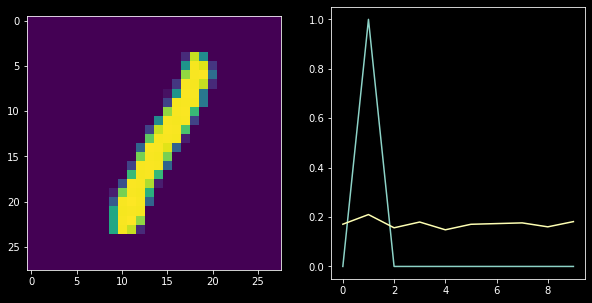

In [16]:
c = 0
while c < 0.2:
    x, y = ds_test.iloc[rnd.randint(0, len(ds_test)-1)]
    pred = forward(model, x)[1][-1]
    c = sum((pred - y)**2)
(fig, [ax1, ax2]) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(x.reshape(28, -1))
ax2.plot(y)
ax2.plot(pred)